In [108]:
from src.data.datasets import SiteDataset
import jax.numpy as jnp
site_data = SiteDataset("5a0546857ecc773753327266")

floor = site_data.floors[0]
trace = floor.traces[0]
matrices = trace.matrices
position = matrices["position"]
wifi = matrices["wifi"]
from numpyro import handlers
import numpyro.distributions as dist
from numpyro import sample, plate
import numpyro
from jax import lax
import numpy as np

In [109]:
height, width = floor.info["map_info"]["height"], floor.info["map_info"]["width"]
floor_uniform = dist.Independent(
    dist.Uniform(low=jnp.array([0, 0]), high=jnp.array([height, width])), 1
)
floor_uniform2 = dist.Independent(
    dist.Uniform(low=jnp.array([-1, -1]), high=jnp.array([1, 1])), 1
)


In [110]:
def f(carry, noise_t):
  x_pre,sigma = carry
  x_t = x_pre + sigma*noise_t
  x_pre = x_t
  return (x_pre, sigma), x_t

In [111]:
def initial_model(wifi, position=None, pos_is_observed=None, pos_is_not_observed=None):
    #T = position.shape[0]
    T = wifi.shape[0]
    K = wifi.shape[1]
    
    pos_observed = None if position is None else position[pos_is_observed]

    sigma_eps = 0.1/200
    sigma = 0.1/200

    mu_omega_0 = -45/200
    sigma_omega_0 = 5/200
    #sigma_omega = 2/200

    with plate("wifis", K):
        omega_0 = sample("omega_0", dist.Normal(mu_omega_0, sigma_omega_0))
        #wifi_locations = sample("wifi_location", floor_uniform)
        wifi_locations = sample("wifi_location", floor_uniform2)

    x = jnp.zeros((T, 2))

    #x0 = sample("x_0", floor_uniform)
    x0 = sample("x_0", floor_uniform2)

    noises = sample("noises", fn=dist.Normal(0, 1), sample_shape=(T - 1, 2))
    # Propagate the dynamics forward using jax.lax.scan
    carry = (x0, sigma)
    x_collection = [x0]
    carry, x = lax.scan(f, carry, noises, T - 1)
    x = jnp.concatenate((jnp.array(x_collection), x), axis=0)

    x_hat = sample(
        name="x_hat",
        fn=dist.Normal(loc=x[pos_is_observed], scale=sigma_eps),
        obs=pos_observed,
    )

    # n_train ... n_test. 

    #x_hat_mis = sample(
    #    name="x_hat_mis",
    #    fn=dist.Normal(loc=x[pos_is_not_observed], scale=sigma_eps),
    #    obs=pos_observed,
    #)

    #return x
    
with handlers.seed(rng_seed=0):
    print(initial_model(wifi, position))


None


In [113]:
wifi2 = wifi.copy()
wifi2[:200,:] = np.NAN
#wifi2[250:,:] = np.NAN
wifi[200:,:] = np.NAN
#position[200:,:] = np.NAN

In [114]:
import time
from jax import random, vmap
from numpyro.infer import MCMC, NUTS
import numpy as np

t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

pos_is_observed = ~jnp.isnan(position[:, 0])
pos_is_not_observed = jnp.isnan(position[:, 0])

position2 = position / np.array([width,height])[None,:]-0.5

numpyro.set_host_device_count(4)

nuts_kernel = NUTS(model=initial_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=4)
mcmc.run(
    rng_key_,
    wifi=jnp.array(wifi),
    position=jnp.array(position2),
    pos_is_not_observed=pos_is_not_observed,
    pos_is_observed=pos_is_observed,
)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0) / 60))


/home/simon/Documents/indoor-location-navigation/.venv/lib/python3.8/site-packages/numpyro/infer/mcmc.py:257: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn('There are not enough devices to run parallel chains: expected {} but got {}.'
sample: 100%|██████████| 2000/2000 [00:10<00:00, 198.05it/s, 127 steps of size 4.04e-02. acc. prob=0.92]


Total time: 0.826m


In [115]:
mcmc.print_summary()


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
         noises[0,0]      0.09      0.97      0.09     -1.56      1.59  10887.06      1.00
         noises[0,1]      0.47      0.99      0.47     -1.16      2.02   9096.14      1.00
         noises[1,0]      0.10      0.99      0.10     -1.58      1.69  11750.41      1.00
         noises[1,1]      0.49      1.01      0.49     -1.19      2.07  14973.97      1.00
         noises[2,0]      0.10      0.96      0.09     -1.49      1.60  13111.71      1.00
         noises[2,1]      0.48      1.01      0.48     -1.23      2.11  12372.59      1.00
         noises[3,0]      0.09      0.99      0.10     -1.60      1.60  11097.23      1.00
         noises[3,1]      0.48      0.97      0.49     -1.18      2.01  10697.49      1.00
         noises[4,0]      0.10      1.02      0.10     -1.68      1.70  10532.63      1.00
         noises[4,1]      0.48      1.01      0.47     -1.22      2.07  11810.08      1.0

In [116]:
hmc_samples2 = {k: v for k, v in mcmc.get_samples().items()}

In [117]:
X2 = hmc_samples2["x_0"] + jnp.cumsum(hmc_samples2["noises"], axis = 1).transpose((1,0,2))*0.1/200

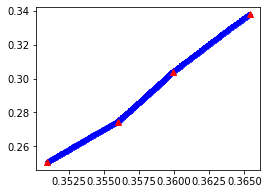

In [118]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
plt.plot(*jnp.mean(X2, axis=1).T, 'b*')
plt.plot(*position2[pos_is_observed].T, 'r^')
plt.show()

## Prediction

In [85]:
from numpyro.infer import Predictive

In [86]:
 predictive(random.PRNGKey(1), jnp.array(wifi2))

{'noises': DeviceArray([[[-1.8741734 , -0.37198123],
               [ 0.15325564,  2.748518  ],
               [-1.1531812 , -0.16255577],
               ...,
               [ 0.37757868, -0.01572735],
               [ 0.3648971 ,  0.63837546],
               [-1.569876  , -1.3239739 ]],
 
              [[-0.45637745, -0.66470236],
               [-0.54539376, -0.21375754],
               [-0.60648006,  0.10640739],
               ...,
               [ 0.37116858, -0.53916925],
               [ 0.12408159, -0.831645  ],
               [ 0.34983933, -0.45687714]],
 
              [[ 0.72540194,  1.3614142 ],
               [ 0.80761945,  1.2154298 ],
               [ 0.59116524,  0.30199012],
               ...,
               [-1.1976418 ,  0.16862944],
               [ 0.5993    ,  0.31810212],
               [ 1.0015358 ,  0.28330746]],
 
              ...,
 
              [[ 0.8175271 ,  0.29959285],
               [-1.27896   ,  1.4648314 ],
               [ 0.41329265, -0.40872115

In [96]:
wifi

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [97]:
wifi2

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [98]:
predictive = Predictive(initial_model, hmc_samples2, return_sites=["x_0","noises"])
noises = predictive(random.PRNGKey(1), jnp.array(wifi2))[
    "noises"
]
x_0 = predictive(random.PRNGKey(1), jnp.array(wifi2))[
    "x_0"
]

In [106]:
X3 = x_0 + jnp.cumsum(noises, axis = 1).transpose((1,0,2))*0.1/200

In [101]:
sum(sum(X3!=X2))

array([0, 0])

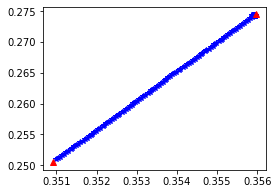

In [107]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
plt.plot(*jnp.mean(X3, axis=1).T, 'b*')
plt.plot(*position2[pos_is_observed].T, 'r^')
plt.show()

In [13]:
from numpyro.infer import Predictive
#initial_model(wifi, position=None, pos_is_observed=None, pos_is_not_observed=None):


predictive = Predictive(initial_model, guide=guide, num_samples=1000,
                        return_sites=("x_hat", "noises"))
samples = predictive(X_train_torch, y_train_torch)

NameError: name 'model' is not defined

In [ ]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

# Compute predictions
y_hat = np.mean(posterior_samples["alpha"].numpy().T + np.dot(X_test, posterior_samples["beta"].numpy().T), axis=1)

In [76]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
X = hmc_samples["x_0"] + jnp.cumsum(hmc_samples["noises"], axis = 1).transpose((1,0,2))*0.1

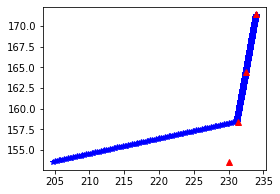

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
plt.plot(*jnp.mean(X, axis=1).T, 'b*')
plt.plot(*position[pos_is_observed].T, 'r^')
plt.show()